In [3]:
import meshio
import numpy as np
from sympy import symbols, Eq, solve, sqrt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
from ipywidgets import interact

In [2]:
# LOAD MESH: [-0.5,0.5]^2, N 25 
mesh_file_path = "/home/aspadotto/meshes/square.msh"
#mesh_file_path = "square_L1_N20.msh"
mesh = meshio.read(mesh_file_path)

# face2node connectivity
faces = mesh.cells[0].data

# node coordinates
coords = mesh.points

# Add dummy column to host faces with more than 3 vertices
faces = np.c_[faces, -1*np.ones(faces.shape[0])]
faces = faces.astype(int)

# Sizes
Nfaces_init = faces.shape[0]
Npoints_init = coords.shape[0]
Nfaces = Nfaces_init
Npoints = Npoints_init

# Mask for elements: 0 if uncut, 1 if cut, 2 if generated by cut
cut_faces = np.zeros(Nfaces)

# central circle radius
rho = 0.25

# gamme_edge2face connectivity (not ordered, created during mesh breaking)
# it is created during mesh breaking

# in/ex mask (0: in, 1: ex, -1: cut cell)
side_mask = -1*np.ones(Nfaces)

# boundary mask, code:
# 0: internal
# 1: x=-0.5
# 2: y=-0.5
# 3: x= 0.5
# 4: y= 0.5
# attention: bnd_mask keeps its size after mesh breaking 
# it is ok as long as intface doesn't touch boundary
bnd_mask = np.zeros(Npoints_init)
for ino in range(Npoints_init):
    if (abs(coords[ino,0]+0.5)<1e-6):
        bnd_mask[ino]= 1  
    if (abs(coords[ino,1]+0.5)<1e-6):
        bnd_mask[ino] = 2
    if (abs(coords[ino,0]-0.5)<1e-6):
        bnd_mask[ino] = 3  
    if (abs(coords[ino,1]-0.5)<1e-6):
        bnd_mask[ino] = 4
            
# ASSUMPTIONS ON MESH
## each node has list of points in counterclock-wise sense
## first 2 points of generated element are on gamma

# other data
sigma_ex = 1
sigma_in = 1

In [43]:
print("Points (initial): ", Npoints, "Coords: ", coords.shape)
print ("Faces (initial): ", Nfaces)

Points (initial):  790 Coords:  (790, 3)
Faces (initial):  1478


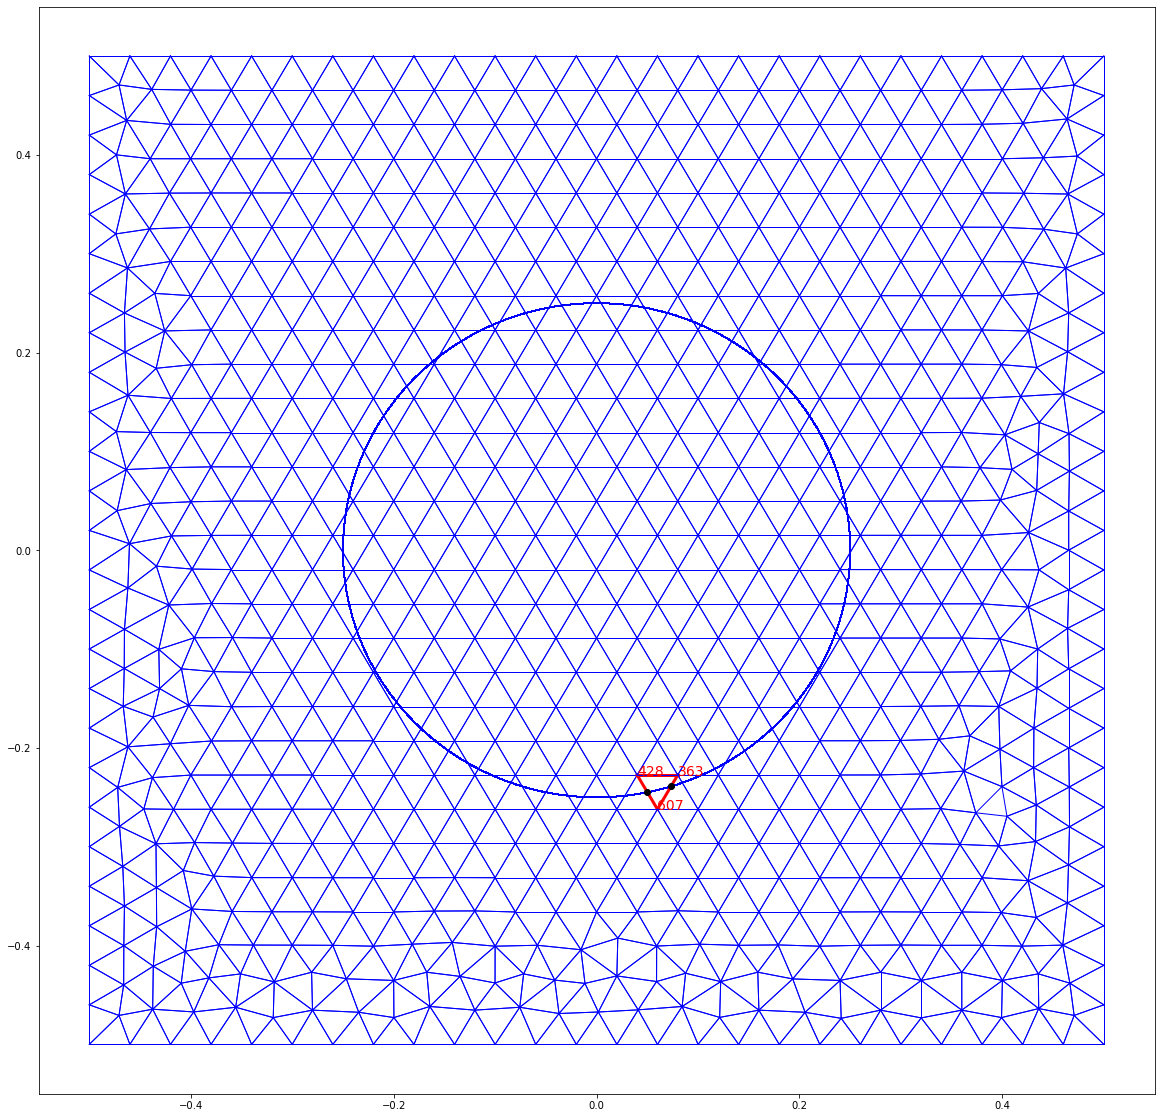

In [44]:
# visualization 

fig, ax = plt.subplots(figsize=(20,20))
for ifa in range(Nfaces-1):
    for ino in range(3):
       p1 = coords[faces[ifa,ino],:]
       p2 = coords[faces[ifa,(ino+1)%3],:]
       dx = p2-p1
       xx = [p1[0],p2[0]]
       yy = [p1[1],p2[1]]
       #ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.005)
       ax.plot(xx,yy,'b', linewidth=1)
       if (ifa==154):
          ax.plot(xx,yy,'r', linewidth=3)
          text_position = p1
          text_content = str(faces[ifa,ino])
          ax.text(p1[0], p1[1], text_content, fontsize=14, color='red')
          [cut, int_coords] = calc_intersection(p1[0], p2[0], p1[1],p2[1])
          if cut:
           #print ("cut! ",int_coords)
           ax.plot(int_coords[0],int_coords[1],'ko', linewidth=4)
       circle = plt.Circle((0, 0), radius=rho, edgecolor='b', facecolor='none')
       ax.add_patch(circle)

In [5]:
def is_proper(value):
    return (value.is_real and abs(value)<=1 and value>0)

def calc_intersection(x1,x2,y1,y2):
    # Define variables
    x, y, t= symbols('x y t')
    # Equation of the circle centered at the origin
    circle_equation = Eq(x**2 + y**2, rho**2)
    # Parametric equations of the line segment
    segment_x = x1 + (x2 - x1) * t
    segment_y = y1 + (y2 - y1) * t
    # Substitute parametric equations into the circle equation
    circle_intersection = circle_equation.subs({x: segment_x, y: segment_y})
    # Solve the resulting quadratic equation for t
    intersection_points = solve(circle_intersection, t)
    #print("Curvilinear abscissa: ", intersection_points)
    if (len(intersection_points)==0):
        return [False, np.array([0.0,0.0,0.0])]
       # Evaluate the parametric equations at the intersection points
    intersection_coordinates = \
       [(segment_x.subs(t, point), segment_y.subs(t, point)) for point in intersection_points]
    #print ("Intersection points: ", intersection_coordinates) 
    if (is_proper(intersection_points[0])):
        #print ("it's the first")
        point = intersection_coordinates[0]
        return [True, np.array([point[0], point[1],0.0])]
    elif (is_proper(intersection_points[1])):
        #print ("it's the second")
        point = intersection_coordinates[1]
        return [True, np.array([point[0], point[1],0.0])]
    else:
        return [False, np.array([0.0,0.0,0.0])]

In [6]:
# check if face is cut
def is_cut(ifa):
    r_min = 1e6
    r_max = 0
    for ino in range(3):
        r = np.linalg.norm(coords[faces[ifa,ino]])
        if (r<=r_min):
            r_min = r
        if (r>=r_max):
            r_max = r
    if (r_min<=rho and rho<=r_max):
        return True
    
# check if point is present
def check_if_present(node_coords):
   for ino in range(Npoints):
        diff = node_coords-coords[ino]
        if (np.dot(diff,diff)<1e-10):
            print ("Point already there")
            return [True, ino]
   return [False, -1] 

In [13]:
def split_face(ifa):
    global Npoints
    global coords
    inters_mask = [0,0,0] #Pattern of intersections to get orientation (if counter_clock)
    vert_mask   = [0,0,0] #Pattern of vertices for orientation (increase if side is cut)
    inters_found = 0      
    int1 = -1             #idx intersection
    int2 = -1 
    # Loop over Edges to find intersection
    for ie in range(3):
        ino1 = faces[ifa,ie]
        ino2 = faces[ifa, (ie+1)%3]
        point1 = coords[ino1,:]
        point2 = coords[ino2,:]
        [cut, int_coords] = calc_intersection(point1[0], point2[0], point1[1],point2[1])
        int_coords = int_coords.astype(float)
        if cut:
            # Add point if not already there
            [present, idx] = check_if_present (int_coords)
            if(not present):
                Npoints = Npoints + 1
                coords = np.vstack([coords,np.array([int_coords[0], int_coords[1], 0.0])])
                idx = Npoints-1
            # Mark index
            if (inters_found == 0):
                int1 = idx
                inters_found = inters_found + 1
            else:
                int2 = idx
            # Update Vert mask
            vert_mask [ie] = vert_mask[ie] + 1
            vert_mask [(ie+1)%3] = vert_mask [(ie+1)%3] + 1
            # Update inters_mask
            inters_mask[ie] = 1
    # Get index of vertices in the right order
    vert_mask = np.array(vert_mask)
    loc_v1 = np.where(vert_mask == 2)[0][0]
    print ("vertex mask: ", vert_mask)
    print ("inters_mask: ", inters_mask)
    print("pos of v1: ",loc_v1)
    v1 = faces[ifa,loc_v1]
    v2 = faces[ifa,(loc_v1+1)%3]
    v3 = faces[ifa,(loc_v1+2)%3]
    # Put intersection in right order
    if (inters_mask==[1,1,0] or inters_mask==[0,1,1]):
        int_prec = int1
        int_fol  = int2
    else:
        int_prec = int2
        int_fol  = int1
    # Define list of ordered vertices of new elements (the triangle first)
    # Notice that cut edge is the first
    l1 = [int_fol,int_prec,v1,-1]
    l2 = [int_prec,int_fol,v2,v3]
    return [l1,l2]
    
            

In [8]:
def barycenter (ifa):
    node_per_face = np.count_nonzero(faces[ifa,:] != -1)
    x_T = np.zeros(3)
    for ino in range(node_per_face):
        x_T = x_T + coords[faces[ifa,ino],:]
    return x_T/node_per_face

def calc_surface(ifa):
    #shoelace formula
    mod_F = 0
    node_per_face = np.count_nonzero(faces[ifa,:] != -1)
    for ino in range(node_per_face):
        x1 = coords[faces[ifa,ino],0]
        y1 = coords[faces[ifa,ino],1]
        x2 = coords[faces[ifa,(ino+1)%node_per_face],0]
        y2 = coords[faces[ifa,(ino+1)%node_per_face],1]
        mod_F = mod_F + x1*y2 - x2*y1
    mod_F = 0.5*mod_F
    return mod_F
        
def simpson (a, b, fun, with_s = False, sign = 'plus'):
    # a, b: points in 2D space (np arrays)
    # fun: real function with double argument
    mid1 = a + (b-a)/4
    mid2 = a + (b-a)*2/4
    mid3 = a + (b-a)*3/4
    if   (with_s and sign =='minus'):
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        24*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                        8*fun(mid3[0],mid3[1]))
    elif (with_s and sign =='plus'):
        return  np.linalg.norm(b-a)/90*(8*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                       24*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))
    else: 
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        32*fun(mid1[0],mid1[1]) +
                                        12*fun(mid2[0],mid2[1]) + 
                                        32*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))

In [9]:
# MESH BREAKING
for ifa in range(Nfaces_init):
    #Check if face is cut by circle
    if (is_cut(ifa)):
        print ("Face: ", ifa)
        # Mask the Face
        cut_faces[ifa] = 1
        # Create new nodes and faces
        [f1,f2] = split_face(ifa)
        print (f1,f2)
        # Update list of faces and mask
        faces = np.vstack([faces,np.array(f1)])
        faces = np.vstack([faces, np.array(f2)])
        cut_faces=np.append(cut_faces,2)
        cut_faces=np.append(cut_faces,2)
        Nfaces = Nfaces + 2
        # Update side_mask
        side_mask=np.append(side_mask,-1)
        side_mask=np.append(side_mask,-1)
        if (np.linalg.norm(barycenter(Nfaces-2))<rho):
            side_mask[Nfaces-2] = 0
        else:
            side_mask[Nfaces-2] = 1
        if (np.linalg.norm(barycenter(Nfaces-1))<rho):
            side_mask[Nfaces-1] = 0
        else:
            side_mask[Nfaces-1] = 1       
        # Update gamma_edge (first is internal)
        if ("gamma_edges" in globals()):
            if (side_mask[Nfaces-2]==0):
                gamma_edges = np.vstack([gamma_edges, np.array([Nfaces-2, Nfaces-1])])
            else:
                gamma_edges = np.vstack([gamma_edges, np.array([Nfaces-1, Nfaces-2])])
        else:
            if (side_mask[Nfaces-2]==0):
                gamma_edges = np.array([Nfaces-2, Nfaces-1])
            else:
                gamma_edges = np.array([Nfaces-1, Nfaces-2])
    elif (np.linalg.norm(barycenter(ifa))<rho):
        side_mask[ifa] = 0
    else:
        side_mask[ifa] = 1
        
        

IndexError: index 1491 is out of bounds for axis 0 with size 20

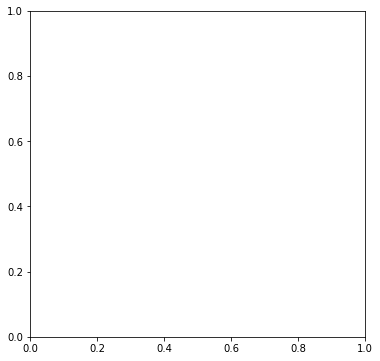

In [10]:
# visualization 
fig, ax = plt.subplots(figsize=(6,6))
ifa = 1491
node_per_face = np.count_nonzero(faces[ifa,:] != -1)
for ino in range(node_per_face):
    p1 = coords[faces[ifa,ino],:]
    p2 = coords[faces[ifa,(ino+1)%node_per_face],:]
    dx = p2-p1
    xx = [p1[0],p2[0]]
    yy = [p1[1],p2[1]]
    ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.005)
    #ax.plot(xx,yy,'b', linewidth=1)
    #ax.plot(xx,yy,'r', linewidth=3)
    text_position = p1
    text_content = str(faces[ifa,ino])
    ax.text(p1[0], p1[1], text_content, fontsize=14, color='red')
    tangent = (p2-p1)[0:2]
    normal = np.array([[0,1],[-1,0]])@tangent
    norm = normal/np.linalg.norm(normal)
    midpoint = p1+0.5*dx
    ax.arrow(midpoint[0],midpoint[1],normal[0],normal[1])
    p = barycenter(ifa)
    ax.scatter(p[0],p[1],color='red')

In [11]:
# check total surf

tot_surf = 0.0
for ifa in range(Nfaces):
    if (cut_faces[ifa]!=1):
        tot_surf = tot_surf+calc_surface(ifa)
    
print ("total surface: ", tot_surf)

total surface:  -6.938893903907228e-18


NameError: name 'gamma_edges' is not defined

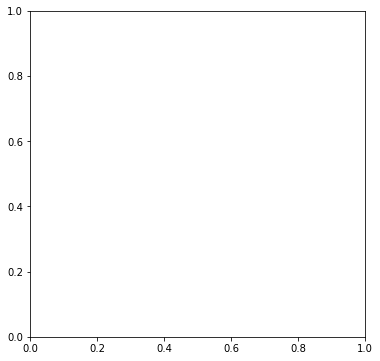

In [12]:
# visualization 
fig, ax = plt.subplots(figsize=(6,6))
ifa_in = gamma_edges[10,0]
ifa_ex = gamma_edges[10,1]

node_per_face_in = np.count_nonzero(faces[ifa_in,:] != -1)
for ino in range(node_per_face_in):
    p1 = coords[faces[ifa_in,ino],:]
    p2 = coords[faces[ifa_in,(ino+1)%node_per_face_in],:]
    dx = p2-p1
    xx = [p1[0],p2[0]]
    yy = [p1[1],p2[1]]
    ax.arrow(p1[0],p1[1], dx[0],dx[1], width = 0.0000005, head_width=0.00005)
    #ax.plot(xx,yy,'b', linewidth=1)
    #ax.plot(xx,yy,'r', linewidth=3)
    text_position = p1
    text_content = str(ino)+","+str(faces[ifa_in,ino])
    ax.text(p1[0], p1[1], text_content, fontsize=14, color='red')
    
node_per_face_ex = np.count_nonzero(faces[ifa_ex,:] != -1)
for ino in range(node_per_face_ex):
    p1 = coords[faces[ifa_ex,ino],:]
    p2 = coords[faces[ifa_ex,(ino+1)%node_per_face_ex],:]
    dx = p2-p1
    xx = [p1[0],p2[0]]
    yy = [p1[1],p2[1]]
    ax.arrow(p1[0],p1[1], dx[0],dx[1], width = 0.0000005, head_width=0.00005)
    #ax.plot(xx,yy,'b', linewidth=1)
    #ax.plot(xx,yy,'r', linewidth=3)
    text_position = p1-1
    text_content = str(ino)+","+str(faces[ifa_ex,ino])
    ax.text(p1[0], p1[1]-0.002, text_content, fontsize=14, color='blue', )

In [ ]:
side_mask[np.where(cut_faces==2)[0]]

In [ ]:
cut_faces[128-2:128+2]

In [ ]:
np.where(side_mask==0)[0]

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
new_Nfaces = faces.shape[0]
for ifa in range(new_Nfaces):
    if (faces[ifa,3]==-1):
        nvert = 3
    else:
        nvert = 4
    for ino in range(nvert):
       p1 = coords[faces[ifa,ino],:]
       p2 = coords[faces[ifa,(ino+1)%nvert],:]
       dx = p2-p1
       xx = [p1[0],p2[0]]
       yy = [p1[1],p2[1]]
       #ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.1)
       if (cut_faces[ifa]==0 or cut_faces[ifa]==1):
          ax.plot(xx,yy,'k', linewidth=0.1)
       if (cut_faces[ifa]==2 and nvert ==3):
           ax.plot(xx,yy,'r', linewidth=1)
       if (cut_faces[ifa]==2 and nvert ==4):
          ax.plot(xx,yy,'b', linewidth=1)
    circle = plt.Circle((0, 0), radius=rho, edgecolor='g', facecolor='none')
    ax.add_patch(circle)

# mark generated points
for ino in range(Npoints):
    if (ino>=Npoints_init):
        xx = coords[ino,0]
        yy = coords[ino,1]    
        point = ax.scatter(xx,yy,color='green')

# mark faces according to side
for ifa in range(Nfaces):
    if (cut_faces[ifa]!=1):
        p = barycenter(ifa)
        xx = p[0]
        yy = p[1]
        if (side_mask[ifa]==0):
            point = ax.scatter(xx,yy,color='orange')
        else:
            point = ax.scatter(xx,yy,color='violet')
#        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
#        for ino in range(node_per_face):
#            idxx = glob_idx(ino)
#            xx = coords[faces[ifa,ino],0]
#            yy = coords[faces[ifa,ino],1]
#            point = ax.scatter(xx,yy,color='violet')

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
new_Nfaces = faces.shape[0]

for ifa in range(new_Nfaces):
    if (faces[ifa,3]==-1):
        nvert = 3
    else:
        nvert = 4
    for ino in range(nvert):
       p1 = coords[faces[ifa,ino],:]
       p2 = coords[faces[ifa,(ino+1)%nvert],:]
       dx = p2-p1
       xx = [p1[0],p2[0]]
       yy = [p1[1],p2[1]]
       #ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.1)
       if (cut_faces[ifa]==0 or cut_faces[ifa]==1):
          ax.plot(xx,yy,'k', linewidth=0.1)
       if (cut_faces[ifa]==2 and nvert ==3):
           ax.plot(xx,yy,'r', linewidth=1)
       if (cut_faces[ifa]==2 and nvert ==4):
          ax.plot(xx,yy,'b', linewidth=1)
    circle = plt.Circle((0, 0), radius=rho, edgecolor='g', facecolor='none')
    ax.add_patch(circle)

for ied in range(gamma_edges.shape[0]):
    ifa_in = gamma_edges[ied,0]
    ifa_ex = gamma_edges[ied,1]
    xx,yy = barycenter(ifa_in)[0:2]
    point = ax.scatter(xx,yy,color='blue')
    xx,yy = barycenter(ifa_ex)[0:2]
    point = ax.scatter(xx,yy,color='red')
    tangent = coords[faces[ifa_in,1],0:2]-coords[faces[ifa_in,0],0:2]
    sign = 1
    normal = sign*np.array([[0,1],[-1,0]])@tangent 
    normal = 1/20*normal/np.linalg.norm(normal)
    midp = 0.5*(coords[faces[ifa_in,0],:]+coords[faces[ifa_in,1],:])
    ax.arrow(midp[0], midp[1], normal[0],normal[1],head_width=0.005)


In [ ]:
# test Simpson formula
bary = np.array([0,0])
four_points=np.array([[-0.5,-0.5],[0.5,-0.5],[0.5,0.5],[-0.5,0.5]])+np.array([0.5,0.5])
fun = lambda x,y: x*y
pot = lambda x,y: 0.25*np.array([x**2*y, x*(y**2)])
#fun = lambda x,y: 1.
#pot = lambda x,y: 0.5*np.array([x-x_T[0], y-x_T[1]])
#fun = lambda x,y : x+y 
#pot = lambda x,y : np.array([y,x])
integ = 0.
for k in range(4):
                    start = four_points[k]
                    end = four_points[(k+1)%4]
                    tangent = end-start
                    normal = np.dot(np.array([[0,1],[-1,0]]), tangent)
                    n = normal/np.linalg.norm(normal)
                    #print (simpson(start, end, lambda x,y: np.dot(-n,pot(x,y))))
                    #print(-n)
                    integ = integ + simpson(start, end, lambda x,y: np.dot(n,pot(x,y)))
                    
print (integ)

In [ ]:
# Discrete Gradient Matrix (dimSpace(=2) ,node_per_face)
def GR (ifa):
    node_per_face = np.count_nonzero(faces[ifa,:] != -1)
    GR = np.zeros((2, node_per_face))
    for ino in range(node_per_face):
        start1 = end2 = np.array(coords[faces[ifa][ino],0:2]) #dx
        start2 = np.array(coords[faces[ifa,(ino-1)%node_per_face], 0:2]) 
        end1   = np.array(coords[faces[ifa,(ino+1)%node_per_face], 0:2])
        tangent1 = (end1-start1)
        tangent2 = (end2-start2)
        # get normal by rotation
        normal1 = np.array([[0,1],[-1,0]])@tangent1
        normal2 = np.array([[0,1],[-1,0]])@tangent2
        norm1 = normal1/np.linalg.norm(normal1)
        norm2 = normal2/np.linalg.norm(normal2)
        mod_F = calc_surface(ifa)
        GR[:,ino] = 0.5/mod_F*(normal1+normal2)
    return GR

In [ ]:
# Potential RECONSTRUCTION matrix (node_per_face, node_per_face)
def recpot (ifa):
  global Nfaces, faces
  node_per_face = np.count_nonzero(faces[ifa,:] != -1)
  dim_basis     = 3 #dimension of basis of R,c2(T) 
  V = np.zeros ((node_per_face, dim_basis)) #evaluation matrix
  M = np.zeros ((dim_basis, dim_basis))     #the mass matrix to invert
  B1 = np.zeros ((dim_basis,node_per_face))  #the rhs matrix (part 1)
  B2 = np.zeros ((dim_basis,node_per_face))  #the rhs matrix (part 2)
  x_T = barycenter(ifa)
  #define the psi_i (for edge contribution of B)
  psi = [None for _ in range(dim_basis)]
  psi [0] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])
  psi [1] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(x-x_T[0])
  psi [2] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(y-x_T[1])
  #define the phi_i (for V)
  phi = [None for _ in range(dim_basis)]
  phi [0] = lambda x,y: 2.
  phi [1] = lambda x,y: 3*(x - x_T[0])
  phi [2] = lambda x,y: 3*(y - x_T[1])
  #define the csi_ij (integrated phi_i*phi_j, for M)
  csi = [[None for _ in range(dim_basis)] for _ in range (dim_basis)]
  csi [0][0] = lambda x,y: np.array([2*(x-x_T[0]), 
                                       2*(y-x_T[1])])
  csi [0][1] = csi[1][0] = lambda x,y: np.array([0., 
                                                   6*(y-x_T[1])*(x-x_T[0])])
  csi [0][2] = csi[2][0] = lambda x,y: np.array([6*(x-x_T[0])*(y-x_T[1]),
                                                   0.])
  csi [1][1] = lambda x,y: np.array([0., 
                                       9*(y-x_T[1])*((x-x_T[0])**2)])
  csi [1][2] = csi[2][1] = lambda x,y: np.array([(9/4)*((x-x_T[0])**2)*(y-x_T[1]), 
                                                   (9/4)*(x-x_T[0])*((y-x_T[1])**2)])
  csi [2][2] = lambda x,y: np.array([9*(x-x_T[0])*((y-x_T[1])**2),
                                       0.])
  #define the chi_iN  (for cell contribution in B)
  chi_fac = [None for _ in range (dim_basis)]
        #visualization
        #if (t == -1):
        #  fig,ax = plt.subplots(figsize=(4,4))
         #   plt.gca().set_aspect('equal', adjustable='box')
          #  start1 = end2 = np.array(nodes[elements[t][j]]) #dx
           # start2 = np.array(nodes[elements[t][(j-1)%node_per_elem]]) #sx
            #end1 = np.array(nodes[elements[t][(j+1)%node_per_elem]])
           # ax.plot([start1[0], end1[0]], [start1[1], end1[1]],'r')
           # ax.plot([start2[0], end2[0]], [start2[1], end2[1]],'r')
            #ax.plot ([start1[0],start1[0]+ e_avg[0] ],
             #        [start1[1],start1[1]+ e_avg[1]])
  chi_fac[0] = lambda  x,y: np.array([(x-x_T[0])*(y-x_T[1]),
                                        (x-x_T[0])*(y-x_T[1])]) 
  chi_fac[1] = lambda  x,y: np.array([0.5*((x-x_T[0])**2)*(y-x_T[1]),
                                        (y-x_T[1])*((x-x_T[0])**2)]) 
  chi_fac[2] = lambda  x,y: np.array([(x-x_T[0])*((y-x_T[1])**2),
                                        0.5*((y-x_T[1])**2)*(x-x_T[0])]) 
  #fill V  
  for i in range(node_per_face):
        xx = coords[faces[ifa][i]][0]
        yy = coords[faces[ifa][i]][1]
        for j in range(dim_basis):
            V[i][j] = phi[j](xx,yy)
    #fill M
  for i in range (dim_basis):
        for j in range (dim_basis):
            #must sum integrals over E of csi*n 
            for k in range(node_per_face):
                # get direction of edge
                start = coords[faces[ifa][k], 0:2]
                end   = coords[faces[ifa][(k+1)%node_per_face], 0:2]
                tangent = (end-start)/np.linalg.norm(end-start)
                # get normal by rotation
                normal = np.array([[0,1],[-1,0]])@tangent
                M [i][j] = M [i][j] + simpson(start, end, lambda x,y: np.dot(normal,csi[i][j] (x,y)))
  #fill B
  for i in range(dim_basis):
        for j in range (node_per_face):
                #face contribution form left and right (need 2 normals)
                start1 = end2 = np.array(coords[faces[ifa][j],0:2]) #dx
                start2 = np.array(coords[faces[ifa][(j-1)%node_per_face], 0:2]) #sx
                end1   = np.array(coords[faces[ifa][(j+1)%node_per_face], 0:2])
                tangent1 = (end1-start1)
                tangent2 = (end2-start2)
                # get normal by rotation
                normal1 = np.array([[0,1],[-1,0]])@tangent1
                normal2 = np.array([[0,1],[-1,0]])@tangent2
                norm1 = normal1/np.linalg.norm(normal1)
                norm2 = normal2/np.linalg.norm(normal2)
                B2 [i][j] = B2 [i][j] + simpson(start1, end1,
                                              lambda x,y: np.dot(norm1,psi[i](x,y)), True, 'minus')#dx
                B2 [i][j] = B2 [i][j] + simpson(start2, end2, 
                                              lambda x,y: np.dot(norm2,psi[i](x,y)), True, 'plus')#sx 
                #cell contribution: must sum integrals over E of chi*n 
                e_avg = 0.5*(normal1 + normal2)
                chi_ij = lambda x,y: np.multiply (np.flip(e_avg), chi_fac[i](x,y))
                for k in range(node_per_face):
                    start = coords[faces[ifa][k],0:2]
                    end = coords[faces[ifa][(k+1)%node_per_face], 0:2]
                    tangent = (end-start)/np.linalg.norm(end-start)
                    # get normal by rotation
                    normal = np.array([[0,1],[-1,0]])@tangent
                    # get surface of face
                    mod_F = calc_surface (ifa)
                    B1[i][j] = B1[i][j] -(1/mod_F)* simpson(start, end, lambda x,y: np.dot(normal,chi_ij(x,y)))
  #calculate the final local matrix S an store it
  R = np.dot(V, np.linalg.solve(M,(B1+B2)))
  return R

In [ ]:
# test reconstruction: initialize poli1 function and check gradient and recpot 
# recpot should be exact for pol1

u = np.zeros(Npoints)
for ino in range(Npoints):
    x = coords[ino,0]
    y = coords[ino,0]
    u[ino] = x + y

for ifa in range(Nfaces):
    print ("Face no:", ifa)
    node_per_face = np.count_nonzero(faces[ifa,:] != -1)
    u_F = u[faces[ifa,0:node_per_face]]
    grad = GR(ifa)
    print("Nodal values", u_F)
    print ("Gradient: ", np.dot(grad,u_F))
    R = recpot(ifa)
    print("Reconstruction", np.dot(R,u_F))
    print ("*************")
    if (np.linalg.norm( u_F- np.dot(R,u_F) )>1e-6):
        print ("Error")

In [ ]:
def plot3D (elevation,azimuth):
    fig = plt.figure(figsize = (15,15))
    ax  = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    for ifa in range(Nfaces):
        if (cut_faces[ifa]!=1):
            node_per_face = np.count_nonzero(faces[ifa,:] != -1)
            xx = np.zeros(node_per_face)
            yy = np.zeros(node_per_face)
            nodal_values = np.zeros(node_per_face)
            for ino in range(node_per_face):
                xx[ino], yy[ino] = coords[faces[ifa][ino],0:2]
            u_F = u[faces[ifa,0:node_per_face]]
            R = recpot(ifa)
            reconstruction = np.dot(R,u_F)
            surf = ax.plot_trisurf(xx,yy, reconstruction, cmap=cm.coolwarm)
    plt.show()

interact(plot3D, elevation=(-90, 90, 5), azimuth=(-180, 180, 5))

In [ ]:
recpot(1641)
u_F = u[faces[1641,0:4]]
print(u_F, np.dot(recpot(1641),u_F))

In [ ]:
# Convention: internal unknowns, intface unknowns side in, intface unknowns side ex
def glob_idx (ifa,ino):
    idx_point = faces[ifa,ino]
    if (idx_point<Npoints_init):
    # point is from the original mesh: not on the int.face
        return idx_point
    else:
    # interface point, doubled: unknown structure: 
    # [internal unknowns, internal intface unk, external intface unknowns]
        side = side_mask[ifa]
        if (side==0):
            return Npoints_init + (idx_point-Npoints_init)
        elif (side==1):
            #return Npoints_init +(Npoints-Npoints_init)+(idx_point-Npoints_init)
            return idx_point + (Npoints-Npoints_init)
        else:
            print ("Error: this face is cut")

# Kronecker Delta
def kron(i,j):
    if (i==j):
        return 1
    else:
        return 0

In [ ]:
# attention: change values of sigma if you are doing a test with no jump
sigma_in = 0.1
sigma_ex = 1

# Define number of dofs
Ndof = Npoints_init + 2*(Npoints-Npoints_init)

# Assemble matrix G (grad-grad)
G = np.zeros((Ndof,Ndof))
for ifa in range(Nfaces):
    side = side_mask[ifa]
    if (cut_faces[ifa] != 1):
        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
        GRAD = GR(ifa)
        mod_F = calc_surface(ifa)
        sigma = (1-side)*sigma_in + side*sigma_ex
        for i in range(node_per_face):
            for j in range(node_per_face):
                glob_i = glob_idx(ifa,i)
                glob_j = glob_idx(ifa,j)
                G[glob_i,glob_j] = G[glob_i,glob_j] +sigma*mod_F*np.dot(GRAD[:,i],GRAD[:,j])

# Assemble matrix S (stabilization)
S = np.zeros((Ndof,Ndof))
for ifa in range(Nfaces):
    if (cut_faces[ifa] != 1):
        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
        R = recpot(ifa)
        for i in range(node_per_face):
            for j in range(node_per_face):
                glob_i = glob_idx(ifa,i)
                glob_j = glob_idx(ifa,j)
                for k in range (node_per_face):
                    S[glob_i,glob_j] = S[glob_i,glob_j] + (R[k,i]-kron(i,k))*(R[k,j]-kron(j,k))

In [ ]:
ax,fig = plt.subplots(figsize=(10,10))
plt.spy(G, markersize=1)

In [ ]:
S[Npoints:, Npoints:]

In [ ]:
gamma_edges.shape[0]

In [ ]:
# Matrix M_gamma (jump of gradient) 

M_gamma = np.zeros((Ndof,Ndof))

for ied in range(gamma_edges.shape[0]):
    # table of dofs touched by the edge
    # 7 dofs: 3 from the triangle + 4 from the quad
    edge_dofs = np.zeros((7,2),dtype=int)
    ifa_in = gamma_edges[ied,0]
    ifa_ex = gamma_edges[ied,1]  
    node_per_face_in = np.count_nonzero(faces[ifa_in,:] != -1)
    node_per_face_ex = np.count_nonzero(faces[ifa_ex,:] != -1)
    # dofs ifa_in
    for ino_in in range(node_per_face_in):
        edge_dofs[ino_in,0] = glob_idx(ifa_in, ino_in)
        edge_dofs[ino_in,1] = ifa_in
    # dofs ifa_ex
    for ino_ex in range(node_per_face_ex):
        edge_dofs[node_per_face_in+ino_ex,0] = glob_idx(ifa_ex, ino_ex)
        edge_dofs[node_per_face_in+ino_ex,1] = ifa_ex
    for idof1 in range(7):
        dof1 = edge_dofs[idof1,0] #global idx
        if (idof1<node_per_face_in): #local idx
            dof1_loc = idof1 
        else:
            dof1_loc = idof1-node_per_face_in
        ifa1 = edge_dofs[idof1,1] #idx of face
        GR1 = GR(ifa1) 
        sigma1 = sigma_in*int(ifa1==ifa_in) + sigma_ex*int(ifa1==ifa_ex)
#       print ("sigma1", sigma1)
        tangent = coords[faces[ifa1,1],0:2]-coords[faces[ifa1,0],0:2]
        sign1 = int(ifa1==ifa_in)-int(ifa1==ifa_ex)
        normal = sign1*np.array([[0,1],[-1,0]])@tangent
        print ("normal", normal)
        #normal = normal/np.linalg.norm(normal)
        mean_sigma_grad_normal = 0.5*sigma1*np.dot(GR1[:,dof1_loc],normal)
        for idof2 in range(7):
            dof2 = edge_dofs[idof2,0] #global idx
            if (idof2<node_per_face_in): #local idx
                dof2_loc = idof2 
            else:
                dof2_loc = idof2-node_per_face_in
            ifa2 = edge_dofs[idof2,1]
            R2 = recpot(ifa2) 
            ## Setting node prec as first vertex and node post as second
            ## should be indifferent though
            node_per_face_2 = np.count_nonzero(faces[ifa2,:] != -1)
            if (node_per_face_2 ==4):
                v2A = R2[0,dof2_loc]
                v2B = R2[1,dof2_loc]
            else:
                v2A = R2[1,dof2_loc]
                v2B = R2[0,dof2_loc]
            # sign (jump must be ex-in)
            sign2 = int(ifa2==ifa_ex)-int(ifa2==ifa_in)
            # contribution
            ## edge length
#            mod_E = np.linalg.norm(coords[faces[ifa2,0],:]-coords[faces[ifa2,1],:])#
#            print ("mod_E", mod_E)
#            print ("norm normal", np.linalg.norm(normal))
            ## integral
            jump_of_rec = 0.5*(v2A+v2B)*sign2
            M_gamma[dof1,dof2] = M_gamma[dof1,dof2] + mean_sigma_grad_normal*jump_of_rec
#            print ("v2A, v2B: ", v2A,v2B)
#            print ("sign2", sign2)
#            print ("sigma1", sigma1)
#            print ("mod_E", mod_E)
#            print ("jump_of_rec", jump_of_rec)
#            print ("mean_sigma_grad_normal", mean_sigma_grad_normal)
#            print ("GR1", GR1)
#            print ("tangent", tangent)
#            print ("normal", normal)
#            print ("mean_sigma_grad_normal", mean_sigma_grad_normal)
#            print ("jump_of_rec", jump_of_rec)

In [ ]:
ax,fig = plt.subplots(figsize=(10,10))
plt.spy(M_gamma, markersize=1)

In [ ]:
# calculate the integral over the [0,1] of the product between 2 affine functions assigned through their 
# values at vertices 0 and 1 (first values at 0 of f1 and f2 an then values at 1)
def calc_r2_prod_integ(v1A,v1B,v2A,v2B): 
    return v1A*v2A*1/3 + (v1A*v2B+v1B*v2A)*1/6 + v1B*v2B*1/3

In [ ]:
# matrix N_gamma (jump penalisation)

N_gamma = np.zeros((Ndof,Ndof))
for ied in range(gamma_edges.shape[0]):
    print ("***********")
    print ("Edge: ", ied)
    # table of dofs touched by the edge
    # 7 dofs: 3 from the triangle + 4 from the quad
    edge_dofs = np.zeros((7,2),dtype=int)
    ifa_in = gamma_edges[ied,0]
    ifa_ex = gamma_edges[ied,1]  
    node_per_face_in = np.count_nonzero(faces[ifa_in,:] != -1)
    node_per_face_ex = np.count_nonzero(faces[ifa_ex,:] != -1)
    # dofs ifa_in
    for ino_in in range(node_per_face_in):
        edge_dofs[ino_in,0] = glob_idx(ifa_in, ino_in)
        edge_dofs[ino_in,1] = ifa_in
    # dofs ifa_ex
    for ino_ex in range(node_per_face_ex):
        edge_dofs[node_per_face_in+ino_ex,0] = glob_idx(ifa_ex, ino_ex)
        edge_dofs[node_per_face_in+ino_ex,1] = ifa_ex
    for idof1 in range(7):
        # get nodal values of reconstruction
        dof1 = edge_dofs[idof1,0] #global idx
        if (idof1<node_per_face_in): #local idx
            dof1_loc = idof1 
        else:
            dof1_loc = idof1-node_per_face_in
        ifa1 = edge_dofs[idof1,1]
        R1 = recpot(ifa1) 
        ## convention: node1 is prec, node2 is post: 
        ## to distinguish must understand what face I'm on, 
        ## the 4-verticed one or the the 3-verticed one 
        node_per_face_1 = np.count_nonzero(faces[ifa1,:] != -1)
        if (node_per_face_1 ==4):
            v1A = R1[0,dof1_loc]
            v1B = R1[1,dof1_loc]
        else:
            v1A = R1[1,dof1_loc]
            v1B = R1[0,dof1_loc]
        # sign (jump must be ex-in)
        sign1 = int(ifa1==ifa_ex)-int(ifa1==ifa_in)
        for idof2 in range(7):
            dof2 = edge_dofs[idof2,0] #global idx
            if (idof2<node_per_face_in): #local idx
                dof2_loc = idof2 
            else:
                dof2_loc = idof2-node_per_face_in
            ifa2 = edge_dofs[idof2,1]
            R2 = recpot(ifa2) 
            # ATTENTION: important detail
            # the order of intface nodes for genrated elements is pos//prec for the one
            # with 3 vertices and prec//pos for the one with 4 vertices (mind the inversion)
            node_per_face_2 = np.count_nonzero(faces[ifa2,:] != -1)
            if (node_per_face_2 ==4):
                v2A = R2[0,dof2_loc]
                v2B = R2[1,dof2_loc]
            else:
                v2A = R2[1,dof2_loc]
                v2B = R2[0,dof2_loc]
            # sign (jump must be ex-in)
            sign2 = int(ifa2==ifa_ex)-int(ifa2==ifa_in)
            # contribution
            ## edge length
            mod_E = np.linalg.norm(coords[faces[ifa2,0],:]-coords[faces[ifa2,1],:])
            ## integral
            local_contrib = calc_r2_prod_integ(v1A,v1B,v2A,v2B) 
#            print ("******")
#            print ("mod_E", mod_E)
#            print ("sign1", sign1)
#            print ("local_contrib", local_contrib)
#            print ("******")
            print ("local dofs: ", dof1_loc, dof2_loc)
            N_gamma[dof1,dof2] = N_gamma[dof1,dof2] + mod_E*sign1*sign2*local_contrib

In [ ]:
ax,fig = plt.subplots(figsize=(10,10))
plt.spy(N_gamma, markersize=1)

In [ ]:
# l.h.s: b_phi (jump penalisation)

# initialize jump datum phi on interface nodes (constant value)
Npoints_intface = Npoints-Npoints_init
phi_datum = np.zeros((Npoints_intface))
for ino in range(Npoints_intface):
    xx = coords[Npoints_init+ino,0]
    yy = coords[Npoints_init+ino,1]
    phi_datum[ino]= 1.0

b_phi = np.zeros((Ndof))
for ied in range(gamma_edges.shape[0]):
    print ("*******")
    # table of dofs touched by the edge
    # 7 dofs: 3 from the triangle + 4 from the quad
    edge_dofs = np.zeros((7,2),dtype=int)
    ifa_in = gamma_edges[ied,0]
    ifa_ex = gamma_edges[ied,1]  
    node_per_face_in = np.count_nonzero(faces[ifa_in,:] != -1)
    node_per_face_ex = np.count_nonzero(faces[ifa_ex,:] != -1)
    # dofs ifa_in
    for ino_in in range(node_per_face_in):
        edge_dofs[ino_in,0] = glob_idx(ifa_in, ino_in)
        edge_dofs[ino_in,1] = ifa_in
    # dofs ifa_ex
    for ino_ex in range(node_per_face_ex):
        edge_dofs[node_per_face_in+ino_ex,0] = glob_idx(ifa_ex, ino_ex)
        edge_dofs[node_per_face_in+ino_ex,1] = ifa_ex   
    for idof in range(7):
        # get nodal values of reconstruction
        dof = edge_dofs[idof,0] #global idx
        if (idof<node_per_face_in): #local idx
            dof_loc = idof 
        else:
            dof_loc = idof-node_per_face_in
        ifa = edge_dofs[idof,1]
        R = recpot(ifa)
        # vertex 1 = node prec
        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
        if (node_per_face ==4):
            v1A = R[0,dof_loc]
            v1B = R[1,dof_loc]
        else:
            v1A = R[1,dof_loc]
            v1B = R[0,dof_loc]        
        # get nodal values of phi_datum
        # vertex 1 = node prec
        if (node_per_face ==4):        
            ino1 = faces[ifa,0]
            ino2 = faces[ifa,1]
        else:
            ino1 = faces[ifa,1]
            ino2 = faces[ifa,0]                
        ## attention: indexes are shifted
        v2A = phi_datum[ino1-Npoints_init]
        v2B = phi_datum[ino2-Npoints_init]
        print (v1A, v1B)
        ## edge length
        mod_E = np.linalg.norm(coords[faces[ifa,0],:]-coords[faces[ifa,1],:])
        # sign (jump must be ex-in)
        sign = int(ifa==ifa_ex)-int(ifa==ifa_in)
        # local contribution
        local_contrib = calc_r2_prod_integ(v1A,v1B,v2A,v2B) 
        # integral 
        b_phi[dof] = b_phi[dof] + mod_E*sign*local_contrib
        
#        print (mod_E)

In [ ]:
# l.h.s: b_j (flux jump): SOLO COPIATO b_phi: modificare

# initialize jump datum phi on interface nodes (constant value)
Npoints_intface = Npoints-Npoints_init
j_datum = np.zeros((Npoints_intface))
for ino in range(Npoints_intface):
    xx = coords[Npoints_init+ino,0]
    yy = coords[Npoints_init+ino,1]
    j_datum[ino]= 1.0

b_phi = np.zeros((Ndof))
for ied in range(gamma_edges.shape[0]):
    print ("*******")
    # table of dofs touched by the edge
    # 7 dofs: 3 from the triangle + 4 from the quad
    edge_dofs = np.zeros((7,2),dtype=int)
    ifa_in = gamma_edges[ied,0]
    ifa_ex = gamma_edges[ied,1]  
    node_per_face_in = np.count_nonzero(faces[ifa_in,:] != -1)
    node_per_face_ex = np.count_nonzero(faces[ifa_ex,:] != -1)
    # dofs ifa_in
    for ino_in in range(node_per_face_in):
        edge_dofs[ino_in,0] = glob_idx(ifa_in, ino_in)
        edge_dofs[ino_in,1] = ifa_in
    # dofs ifa_ex
    for ino_ex in range(node_per_face_ex):
        edge_dofs[node_per_face_in+ino_ex,0] = glob_idx(ifa_ex, ino_ex)
        edge_dofs[node_per_face_in+ino_ex,1] = ifa_ex   
    for idof in range(7):
        # get nodal values of reconstruction
        dof = edge_dofs[idof,0] #global idx
        if (idof<node_per_face_in): #local idx
            dof_loc = idof 
        else:
            dof_loc = idof-node_per_face_in
        ifa = edge_dofs[idof,1]
        R = recpot(ifa)
        # vertex 1 = node prec
        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
        if (node_per_face ==4):
            v1A = R[0,dof_loc]
            v1B = R[1,dof_loc]
        else:
            v1A = R[1,dof_loc]
            v1B = R[0,dof_loc]        
        # get nodal values of phi_datum
        # vertex 1 = node prec
        if (node_per_face ==4):        
            ino1 = faces[ifa,0]
            ino2 = faces[ifa,1]
        else:
            ino1 = faces[ifa,1]
            ino2 = faces[ifa,0]                
        ## attention: indexes are shifted
        v2A = phi_datum[ino1-Npoints_init]
        v2B = phi_datum[ino2-Npoints_init]
        print (v1A, v1B)
        ## edge length
        mod_E = np.linalg.norm(coords[faces[ifa,0],:]-coords[faces[ifa,1],:])
        # sign (jump must be ex-in)
        sign = int(ifa==ifa_ex)-int(ifa==ifa_in)
        # local contribution
        local_contrib = calc_r2_prod_integ(v1A,v1B,v2A,v2B) 
        # integral 
        b_phi[dof] = b_phi[dof] + mod_E*sign*local_contrib
        
#        print (mod_E)

In [ ]:
def ref_u(x,y):
    return y
def make_product(u):
    return np.dot (G+S+eta*N_gamma-np.transpose(M_gamma),u)
#    return np.dot (G+S+eta*N_gamma-M_gamma,u)

#impose BC(linear) 
def impose_bc_linear(u):
    for ino in range(Npoints_init):
        if (bnd_mask[ino]>0):
            x = coords[ino,0]
            y = coords[ino,1]
            u[ino] = ref_u(x,y)
    return u

#impose_BC(matthieu)
def impose_bc_matthieu(u):
    for ino in range(Npoints_init):
        if (bnd_mask[ino]>0):
            x = coords[ino,0]
            y = coords[ino,1]
            radius = np.sqrt(x**2+y**2)
            u[ino] = x*(1+ (sigma_ex-sigma_in)/(sigma_ex+sigma_in)*(rho/radius)**2)
    return u

# set 0 at border
def impose_zero_at_border(u):
    eps = 1e-6
    mask = (bnd_mask>0)
    for ino in range(Npoints_init):
        if (mask[ino]):
            x = coords[ino,0]
            y = coords[ino,1]
            u[ino] = 0
    return u

In [ ]:
# TEST WITH AFFINE SOLUTION 
# MODE 1: iterative method

# user-defined parameter (must respect the inf-sup condition, big enough)
# NOTICE: it must be big enough, but too big impacts on convergence of iterative solver)
eta = 1


# initial guess: u = 0
b = np.zeros((Ndof))
#b = eta*b_phi
u = np.zeros((Ndof)) 
impose_bc_linear(u)
impose_bc_linear(b)
r = b - make_product(u)
impose_zero_at_border(r)
p = r
rho_0 = np.dot(r,r)
theta = np.dot(p, make_product(p))


it = 0
maxiter = 2000
while (rho_0 > 1e-12 and it<maxiter):
    alpha = rho_0/theta
    u = u + alpha*p 
    impose_bc_linear(u)
    r = r - alpha*make_product(p)
    impose_zero_at_border(r)
    rho_1 = np.dot(r,r)
    beta = rho_1/rho_0
    p = r + beta*p
    impose_zero_at_border(p)
    theta = np.dot(p, make_product(p))
    rho_0 = rho_1
    it = it + 1

print ("Statistics")
print ("iterations: ",it," residual: ", np.linalg.norm(r))

In [ ]:
# SOLVE SYSTEM BY DIRECT METHOD: homogenous dirichlet and constant jump 

# stability parameter:
eta = 1e6
# 1: define u_g s.t. u_g|_bnd=g
b = np.zeros((Ndof))
#b = eta*b_phi
impose_bc_matthieu(b)
#impose_zero_at_border(b)
# 2: impose bnd cnd on matrix
#A_0 = G+S+eta*N_gamma-M_gamma
A_0 = G+S+eta*N_gamma-np.transpose(M_gamma)
for ino in range(Npoints_init):
    if (bnd_mask[ino]>0):
        A_0[ino,:] = 0
        A_0[ino,ino] = 1
# 2: solve
u = np.linalg.solve(A_0, b)

In [ ]:
# Visualization 

def plot3D (elevation,azimuth):
    fig = plt.figure(figsize = (15,15))
    ax  = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    for ifa in range(Nfaces):
        if (cut_faces[ifa]!=1):
            node_per_face = np.count_nonzero(faces[ifa,:] != -1)
            u_F = np.zeros(node_per_face)
            xx  = np.zeros(node_per_face)
            yy  = np.zeros(node_per_face)
            for ino in range(node_per_face):
                xx[ino], yy[ino] = coords[faces[ifa][ino],0:2]
                ino_glob = glob_idx(ifa,ino)
                u_F [ino] = u [ino_glob]
         #   print (xx,yy,u_F)
            surf = ax.plot_trisurf(xx, yy, u_F, cmap=cm.coolwarm)
    plt.show()

interact(plot3D, elevation=(-90, 90, 5), azimuth=(-180, 180, 5))

In [ ]:
# Look at continuous solution of problem with CR=0.1
def plot3D (elevation,azimuth):
    fig = plt.figure(figsize = (15,15))
    ax  = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    for ifa in range(Nfaces):
        if (cut_faces[ifa]!=1):
            node_per_face = np.count_nonzero(faces[ifa,:] != -1)
            u_F = np.zeros(node_per_face)
            err = np.zeros(node_per_face)
            xx  = np.zeros(node_per_face)
            yy  = np.zeros(node_per_face)
            for ino in range(node_per_face):
                xx[ino], yy[ino] = coords[faces[ifa][ino],0:2]
                radius = np.sqrt((xx[ino]**2+yy[ino]**2))
                if (radius>1e-3):
                    cos_theta = xx[ino]/radius
                else:
                    cos_theta = 0
                if (side_mask[ifa]==0):
                    u_F [ino] = 2*sigma_ex/(sigma_ex+sigma_in)*xx[ino]
                else:
                    u_F [ino] = xx[ino]*( 1+ (sigma_ex-sigma_in)/(sigma_ex+sigma_in)*(rho/radius)**2)         
                err[ino] = abs(u_F[ino]-u[glob_idx(ifa,ino)])
             #   print (xx,yy,u_F)
            surf = ax.plot_trisurf(xx, yy, err, cmap=cm.coolwarm)
    plt.show()

interact(plot3D, elevation=(-90, 90, 5), azimuth=(-180, 180, 5))

In [ ]:
# test subset of matrices (DIRECT METHOD)

# stability parameter:
eta = 1e5
# 1: define u_g s.t. u_g|_bnd=g
u_g = np.zeros((Ndof))
impose_bc(u_g)
# 2: impose bnd cnd on matrix
A_0 = G+S+eta*N_gamma
for ino in range(Npoints_init):
    if (bnd_mask[ino]>0):
        A_0[ino,:] = 0
        A_0[ino,ino] = 1
# 2: solve
u = np.linalg.solve(A_0, u_g)


In [ ]:
# Visualization 

def plot3D (elevation,azimuth):
    fig = plt.figure(figsize = (15,15))
    ax  = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    for ifa in range(Nfaces):
        if (cut_faces[ifa]!=1):
            node_per_face = np.count_nonzero(faces[ifa,:] != -1)
            u_F = np.zeros(node_per_face)
            xx  = np.zeros(node_per_face)
            yy  = np.zeros(node_per_face)
            for ino in range(node_per_face):
                xx[ino], yy[ino] = coords[faces[ifa][ino],0:2]
                ino_glob = glob_idx(ifa,ino)
                u_F [ino] = u [ino_glob]
         #   print (xx,yy,u_F)
            surf = ax.plot_trisurf(xx, yy, u_F, cmap=cm.coolwarm)
    plt.show()

interact(plot3D, elevation=(-90, 90, 5), azimuth=(-180, 180, 5))

In [ ]:
print ("NORMS:")
print ("G", np.linalg.norm(G))
print ("S", np.linalg.norm(S))
print ("M_gamma", np.linalg.norm(M_gamma))
print ("eta*N_gamma", eta*np.linalg.norm(N_gamma))